Let's go through the code step by step and explain what each part does.

1. Importing Libraries:
   - `numpy` is imported as `np`.
   - `random` is imported.
   - `operator` is imported.
   - `array` is imported from the `array` module.
   - `math` is imported.

2. Initializing Parameters:
   - `population_size` is set to 10.
   - `pc` (probability of crossover) is set to 0.6.
   - `pm` (probability of mutation) is set to 0.1.

3. Setting the Random Seed:
   - The random seed is set using `random.seed()` with the argument `random.random()`.

4. Fitness Function:
   - The fitness function takes two parameters, `x` and `y`.
   - It calculates the fitness value based on the given mathematical formula.
   - The fitness value is the sum of two terms, `firstTerm` and `secondTerm`.
   - The fitness value is returned.

5. Mapping Functions:
   - `MapBitsToNatural` function converts a binary number to its corresponding decimal representation.
   - `MapNaturaltoBits` function converts a decimal number to its corresponding binary representation.
   - `MapNautalToSearchSpace` function maps a natural number to a search space.

6. Crossover Function:
   - The `CrossOver` function takes a dictionary of selected numbers as input.
   - It performs crossover between pairs of selected numbers based on the probability of crossover (`pc`).
   - The crossover is performed by swapping bits between the two numbers.
   - The updated dictionary of selected numbers is returned.

7. Initializing the Population:
   - The `InitPopulation` function initializes the population of individuals.
   - It creates a dictionary called `generations` to store the individuals.
   - For each individual, a random `x` and `y` value is generated within a specified range.
   - The fitness value is calculated for each individual using the `fitness` function.
   - The binary representation of `x` and `y` is obtained using the `MapNaturaltoBits` function.
   - The `xy` value is created by concatenating the binary representations of `x` and `y`.
   - The individual is added to the `generations` dictionary with its corresponding fitness value.
   - The `generations` dictionary is returned.

8. Mutation Function:
   - The `Mutation` function takes a dictionary of selected numbers as input.
   - It performs mutation on each selected number based on the probability of mutation (`pm`).
   - For each bit in the selected number, a random number is generated.
   - If the random number is less than or equal to `pm`, the bit is flipped.
   - The updated dictionary of selected numbers is returned.

9. Decode and Calculate Fitness Function:
   - The `DecodeAndCalFitness` function takes a dictionary of selected numbers as input.
   - It decodes the binary representation of `x` and `y` for each selected number.
   - The decoded values are mapped to the search space using the `MapNautalToSearchSpace` function.
   - The fitness value is calculated for each selected number using the `fitness` function.
   - The best fitness value and corresponding `xy` value are tracked.
   - The fitness values are updated in the dictionary of selected numbers.
   - The updated dictionary, best fitness value, and best `xy` value are returned.

10. 5-K Tournament Selection Function:
    - The `tournament5` function takes a dictionary of individuals as input.
    - It performs a 5-K tournament selection process to select the best individuals.
    - For each individual, 5 random individuals are selected from the population.
    - The individual with the lowest fitness value is chosen as the winner.
    - The selected individuals are added to a new dictionary called `NewgenerationDictN`.
    - The `NewgenerationDictN` dictionary is returned.

11. Genetic Algorithm Function:
    - The `GA` function implements the genetic algorithm.
    - It initializes the generation count (`t`), maximum iteration count (`maxIteration`), best fitness value (`bestfitness`), best `xy` value (`bestXY`), and iteration count when the best solution is found (`IterFound`).
    - The population is initialized using the `InitPopulation` function.
    - The main loop runs until the maximum iteration count is reached.
    - In each iteration, the tournament selection, crossover, mutation, and fitness calculation are performed.
    - If a better fitness value is found, the best fitness value, best `xy` value, and iteration count are updated.
    - The loop counter (`t`) is incremented.
    - The best fitness value, best `xy` value, and iteration count when the best solution is found are returned.

12. Running the Genetic Algorithm:
    - The `bestfitness`, `bestXY`, and `IterFound` values are obtained by calling the `GA` function.

13. Decoding the Best Solution:
    - The `x` and `y` values are extracted from the `bestXY` string.
    - The binary representations of `x` and `y` are converted to decimal using the `MapBitsToNatural` function.
    - The decimal values are mapped to the search space using the `MapNautalToSearchSpace` function.
    - The best fitness value, mapped `x` value, mapped `y` value, and iteration count when the best solution is found are printed.

## Fisrt step: translate the fitness funcion to our SNN function
WE need to find a way to tell python that we want to run a command in the terminal.
-> If you use the "!" symbol, you can run terminal commands in the notebook.

In [15]:
import numpy as np
import random
from random import randint
import operator
from array import *
import operator
import math
import time
import itertools

# Initialize parameters
population_size = 12
num_next_generation = 20
num_childs = 4
pc = 0.6  # Probability of crossover
pm = 0.1  # Probability of mutation

random.seed(random.random())

# Fitness function
def fitness(x, y):
    firstTerm = -1 * (abs(0.5 * x * (math.sin(math.sqrt(abs(x))))))
    secondTerm = -1 * (abs(y * math.sin(30 * math.sqrt(abs(x / float(y))))))
    return firstTerm + secondTerm

# Mapping functions
def encode_and_scale(real_value, min_value, max_value, num_bits):
    scaled_value = int((real_value - min_value) / (max_value - min_value) * (2**num_bits - 1))
    binary_representation = bin(scaled_value)[2:].zfill(num_bits)
    return binary_representation

def decode_and_rescale(encoded_value, min_value, max_value, num_bits):
    scaled_value = int(encoded_value, 2)
    real_value = min_value + scaled_value / (2**num_bits - 1) * (max_value - min_value)
    return real_value


# Crossover function
def CrossOver(SelectedNumbersDict):
    NewGenFromSelected = {}
    j = 0
    for i in range(0, len(SelectedNumbersDict), 2):
        randnum = random.random()
        if randnum <= pc:
            num1 = SelectedNumbersDict[i]["xy"]
            num2 = SelectedNumbersDict[i + 1]["xy"]

            # Perform single-point crossover
            crossover_point = random.randint(1, len(num1) - 1)
            child1 = num1[:crossover_point] + num2[crossover_point:]
            child2 = num2[:crossover_point] + num1[crossover_point:]

            # Add the children to the new generation
            NewGenFromSelected[j] = {"xy": child1}
            j += 1
            NewGenFromSelected[j] = {"xy": child2}
            j += 1


    return NewGenFromSelected

# Initialize the population
def InitPopulation():
    generations = {}
    for i in range(population_size):
        randomx = random.randint(10, 1000)
        randomy = random.randint(10, 1000)
        fit = fitness(randomx, randomy)
        xbin = encode_and_scale(randomx, 10, 1000, 10)
        ybin = encode_and_scale(randomy, 10, 1000, 10)
        xy = xbin + ybin
        generations[i] = {"xy": xy, "fitness": fit}
    return generations

# Mutation function
def Mutation(individual):
    encoded_value = individual["xy"]
    mutated_encoded_value = ''.join(
        '0' if bit == '1' and random.random() < pm else '1' if bit == '0' and random.random() < pm else bit
        for bit in encoded_value
    )
    individual["xy"] = mutated_encoded_value
    return individual

# Decode the fitness and calculate it for each new generation
def DecodeAndCalFitness(SelectedNumbersDict):
    bestfit = float('inf')  # Initialize to positive infinity
    bestXY = ""
    
    for _, individual in SelectedNumbersDict.items():
        num = individual["xy"]
        x = num[:10]
        y = num[10:]


        mapX = decode_and_rescale(x, 10, 1000, 10)
        mapY = decode_and_rescale(y, 10, 1000, 10)

        fit = fitness(mapX, mapY)
        individual["fitness"] = fit

        if fit < bestfit:
            bestfit = fit
            bestXY = num

    return SelectedNumbersDict, bestfit, bestXY


def tournament5(generationDictN):
    choice_list = list(generationDictN.keys())
    NewgenerationDictN = {}
    
    for i in range(population_size):
        ktournament = []
        bestNum = 0
        bestFit = float('inf')  # Initialize to positive infinity
        best_randomNum = 0
        
        for j in range(5):
            if not choice_list:
                break  # Exit the loop if choice_list is empty
            random_index = random.choice(choice_list)
            randomNum = generationDictN[random_index]
            ktournament.append(randomNum)
            
            if randomNum["fitness"] < bestFit:
                bestFit = randomNum["fitness"]
                bestNum = randomNum["xy"]
                best_randomNum = random_index

        if best_randomNum in choice_list:
            choice_list.remove(best_randomNum)
        
        if not ktournament:
            continue  # Skip iteration if ktournament is empty
        
        NewgenerationDictN[i] = {"xy": bestNum, "fitness": bestFit}

    return NewgenerationDictN




# Genetic Algorithm
def GA():
    t = 0
    maxIteration = 1000
    bestfitness = float('inf')  # Initialize to positive infinity
    bestXY = ""
    IterFound = 0
    generationDictN = InitPopulation()

    while t < maxIteration:
        SelectedNumbersDict = tournament5(generationDictN)
        SelectedNumbersDict = CrossOver(SelectedNumbersDict)

        # Apply mutation to each individual separately
        SelectedNumbersDict = {key: Mutation(individual) for key, individual in SelectedNumbersDict.items()}

        generationDictN, bestfit, bestXandY = DecodeAndCalFitness(SelectedNumbersDict)

        if bestfit < bestfitness:
            bestfitness = bestfit
            bestXY = bestXandY
            IterFound = t

        t += 1

    return bestfitness, bestXY, IterFound



bestfitness, bestXY, IterFound = GA()

x = bestXY[:10]
y = bestXY[10:]

mapX = decode_and_rescale(x, 10, 1000, 10)
mapY = decode_and_rescale(y, 10, 1000, 10)


print("Best Fitness:", bestfitness)
print("Mapped X:", mapX)
print("Mapped Y:", mapY)
print("Iteration Found:", IterFound)


Best Fitness: -1187.8645208562364
Mapped X: 582.9032258064517
Mapped Y: 959.3548387096774
Iteration Found: 3


This code implements a Genetic Algorithm (GA) to solve an optimization problem. Let's break down the code step by step:

1. The code begins by importing necessary libraries such as `numpy`, `random`, `operator`, `array`, `math`, and `time`.

2. Next, the code initializes various parameters such as `population_size`, `num_next_generation`, `num_childs`, `pc` (probability of crossover), and `pm` (probability of mutation).

3. The `fitness` function is defined, which takes two parameters `x` and `y` and calculates the fitness value based on a mathematical formula. The fitness function is used to evaluate the quality of each individual in the population.

4. Two mapping functions, `encode_and_scale` and `decode_and_rescale`, are defined. These functions are used to convert real values to binary representation and vice versa. The `encode_and_scale` function takes a real value, minimum value, maximum value, and number of bits as input and returns the binary representation of the scaled value. The `decode_and_rescale` function takes an encoded value, minimum value, maximum value, and number of bits as input and returns the corresponding real value.

5. The `CrossOver` function is defined, which performs single-point crossover between selected individuals. It takes a dictionary of selected individuals as input and returns a new generation of individuals obtained through crossover.

6. The `InitPopulation` function is defined, which initializes the population by randomly generating individuals with their corresponding fitness values. It returns a dictionary containing the initial population.

7. The `Mutation` function is defined, which introduces random changes (mutations) in an individual's binary representation. It takes an individual as input, performs mutations based on the probability `pm`, and returns the mutated individual.

8. The `DecodeAndCalFitness` function is defined, which decodes the binary representation of individuals, calculates their fitness values, and updates the fitness values in the dictionary. It also keeps track of the best fitness value and corresponding individual found so far. It returns the updated dictionary, best fitness value, and best individual.

9. The `tournament5` function is defined, which performs tournament selection to select individuals for the next generation. It randomly selects 5 individuals from the current generation and chooses the one with the best fitness value as the representative for the next generation. It returns a dictionary containing the selected individuals for the next generation.

10. The `GA` function is defined, which implements the main Genetic Algorithm. It initializes the population, and then iteratively performs selection, crossover, mutation, and fitness calculation until a maximum number of iterations is reached. It keeps track of the best fitness value and corresponding individual found during the iterations. Finally, it returns the best fitness value, best individual, and the iteration at which the best individual was found.

11. The `bestfitness`, `bestXY`, and `IterFound` variables are assigned the values returned by the `GA` function.

12. The `x` and `y` values are extracted from the `bestXY` variable.

13. The `mapX` and `mapY` variables are assigned the real values obtained by decoding and rescaling the `x` and `y` values.

14. Finally, the best fitness value, mapped `x` value, mapped `y` value, and the iteration at which the best individual was found are printed.

In summary, this code implements a Genetic Algorithm to find the optimal solution for a given optimization problem. It uses selection, crossover, and mutation operations to evolve a population of individuals over multiple iterations, aiming to find the individual with the best fitness value. The fitness function, mapping functions, and other helper functions are used to evaluate and manipulate the individuals in the population.

Checl initial population

In [16]:
initialize_population = InitPopulation()
print("Initial Population:")
for _, individual in initialize_population.items():
    print(individual)

Initial Population:
{'xy': '10100000101010000000', 'fitness': -619.3038766218308}
{'xy': '10010100101010000101', 'fitness': -552.9481947552428}
{'xy': '00011111101101110111', 'fitness': -724.6249141286926}
{'xy': '01110101111101111101', 'fitness': -177.1435758620055}
{'xy': '10100000100110111110', 'fitness': -429.851414862811}
{'xy': '10000001111000001000', 'fitness': -666.8772507833196}
{'xy': '01001111101100001100', 'fitness': -496.9940858931501}
{'xy': '11001010000000110111', 'fitness': -113.3665227686906}
{'xy': '10010000110101000010', 'fitness': -520.2151232748917}
{'xy': '11010111110100110010', 'fitness': -444.4314427167026}
{'xy': '10111001100111000010', 'fitness': -620.4607883312765}
{'xy': '01100011110010011000', 'fitness': -240.52298293973888}


Check tournament selection

In [17]:
tournament5 = tournament5(initialize_population)
print("Tournament 5:")
for _, individual in tournament5.items():
    print(individual)

Tournament 5:
{'xy': '00011111101101110111', 'fitness': -724.6249141286926}
{'xy': '10100000101010000000', 'fitness': -619.3038766218308}
{'xy': '10111001100111000010', 'fitness': -620.4607883312765}
{'xy': '10000001111000001000', 'fitness': -666.8772507833196}
{'xy': '10010000110101000010', 'fitness': -520.2151232748917}
{'xy': '10010100101010000101', 'fitness': -552.9481947552428}
{'xy': '01001111101100001100', 'fitness': -496.9940858931501}
{'xy': '10100000100110111110', 'fitness': -429.851414862811}
{'xy': '11010111110100110010', 'fitness': -444.4314427167026}
{'xy': '01100011110010011000', 'fitness': -240.52298293973888}
{'xy': '01110101111101111101', 'fitness': -177.1435758620055}
{'xy': '11001010000000110111', 'fitness': -113.3665227686906}


Crossover

In [18]:
crossover = CrossOver(tournament5)
print("Crossover:")
for _, individual in crossover.items():
    print(individual,"Before Mutation: ", decode_and_rescale(individual["xy"][:10], 10, 1000, 10), decode_and_rescale(individual["xy"][10:], 10, 1000, 10))

Crossover:
{'xy': '10000001111000001000'} Before Mutation:  512.258064516129 513.2258064516129
{'xy': '10111001100111000010'} Before Mutation:  728.0645161290323 445.48387096774195
{'xy': '10010000110101000101'} Before Mutation:  570.3225806451613 324.51612903225805
{'xy': '10010100101010000010'} Before Mutation:  584.8387096774194 631.2903225806451
{'xy': '01001111101100001110'} Before Mutation:  317.741935483871 766.7741935483871
{'xy': '10100000100110111100'} Before Mutation:  631.2903225806451 439.6774193548387
{'xy': '11010111110100011000'} Before Mutation:  845.1612903225807 280.96774193548384
{'xy': '01100011110010110010'} Before Mutation:  396.1290322580645 182.25806451612905
{'xy': '01110101111101110111'} Before Mutation:  465.80645161290323 868.3870967741935
{'xy': '11001010000000111101'} Before Mutation:  791.9354838709677 69.03225806451613


In [19]:
# Apply mutation to each individual separately
mutation = {key: Mutation(individual) for key, individual in crossover.items()}
print("Mutation:")
for _, individual in mutation.items():
    print(individual,"After Mutation: ", decode_and_rescale(individual["xy"][:10], 10, 1000, 10), decode_and_rescale(individual["xy"][10:], 10, 1000, 10))


Mutation:
{'xy': '10100001011000001000'} After Mutation:  634.1935483870968 513.2258064516129
{'xy': '10111001110111000110'} After Mutation:  729.0322580645161 449.35483870967744
{'xy': '10010000110101000101'} After Mutation:  570.3225806451613 324.51612903225805
{'xy': '10010111101010001010'} After Mutation:  596.4516129032259 639.0322580645161
{'xy': '01001111101110001110'} After Mutation:  317.741935483871 890.6451612903226
{'xy': '10100000000110101100'} After Mutation:  629.3548387096774 424.19354838709677
{'xy': '10000111110100011000'} After Mutation:  535.483870967742 280.96774193548384
{'xy': '01110011110010100010'} After Mutation:  458.06451612903226 166.7741935483871
{'xy': '01111101111101110111'} After Mutation:  496.77419354838713 868.3870967741935
{'xy': '11101010000000111101'} After Mutation:  915.8064516129032 69.03225806451613


In [20]:
# Decode the fitness and calculate it for each new generation
generationDictN, bestfit, bestXandY = DecodeAndCalFitness(mutation)

print("Decode and Calculate Fitness:")
for _, individual in generationDictN.items():
    print(individual)
print("---------------------------")
print("Best Fitness:", bestfit)
print("Best XY:", bestXandY)
print("Iteration Found:", IterFound)

Decode and Calculate Fitness:
{'xy': '10100001011000001000', 'fitness': -495.9752188967616}
{'xy': '10111001110111000110', 'fitness': -569.0523862594868}
{'xy': '10010000110101000101', 'fitness': -555.395704633743}
{'xy': '10010111101010001010', 'fitness': -610.5100181030905}
{'xy': '01001111101110001110', 'fitness': -850.1481264747315}
{'xy': '10100000000110101100', 'fitness': -402.8929231814144}
{'xy': '10000111110100011000', 'fitness': -397.1431685945428}
{'xy': '01110011110010100010', 'fitness': -213.88484333018704}
{'xy': '01111101111101110111', 'fitness': -631.7586541119417}
{'xy': '11101010000000111101', 'fitness': -462.4008778683227}
---------------------------
Best Fitness: -850.1481264747315
Best XY: 01001111101110001110
Iteration Found: 3


In [21]:
#do permutatin example
a = [1,2,3]

import itertools
list(itertools.permutations([1,2]))[0]


(1, 2)

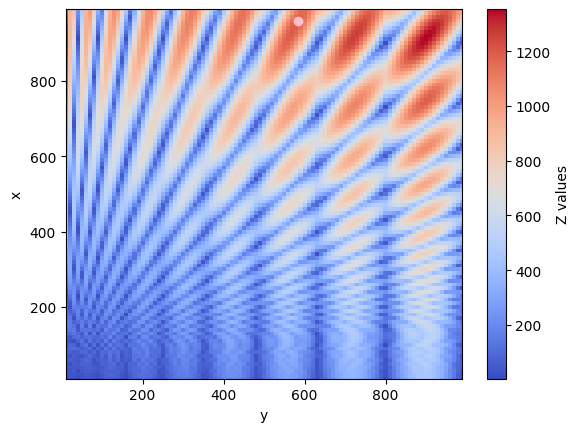

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Generate data
X = np.arange(10, 1000, 10)
Y = np.arange(10, 1000, 10)
X, Y = np.meshgrid(X, Y)
Z = (abs(0.5 * X * (np.sin(np.sqrt(abs(X)))))) + (abs(Y * np.sin(30 * np.sqrt(abs(X / Y)))))

# Create a color plot
plt.pcolormesh(X, Y, Z, cmap=cm.coolwarm, shading='auto')

# Add colorbar
plt.colorbar(label='Z values')

# Set axis limits
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())

# Set axis labels
plt.xlabel('X')
plt.ylabel('Y')

# Show the plot
# plt.show()


#plot the best fitness
plt.plot(mapX,mapY,'o', color='pink')
plt.ylabel('x')
plt.xlabel('y')
plt.show()


# Algorithm 2: Genetic Algorithm for SNN

In [23]:
#intitila parameters
population_size=10
pc=0.6
pm=0.1 #probability of mutation (

random.seed(random.random())

In [24]:
# import subprocess
# import re

# def run_SNN(N_ev, N_ep, NL0, NL1, tau_m, tau_s, tau_plus, tau_minus, a_plus, a_minus, CFI0, CF01, CFI1, alpha, TH0, TH1, file_id_GS):
#     try:

#         command = f'../SNNT13.out --N_ev {N_ev} --N_ep {N_ep} --NL0 {NL0} --NL1 {NL1} --tau_m {tau_m} --tau_s {tau_s} --tau_plus {tau_plus} --tau_minus {tau_minus} --a_plus {a_plus} --a_minus {a_minus} --CFI0 {CFI0} --CF01 {CF01} --CFI1 {CFI1} --alpha {alpha} --TH0 {TH0} --TH1 {TH1} --file_id_GS {file_id_GS}'
        

#         result = subprocess.run(command, shell=True, capture_output=True, text=True)
        

#         relevant_lines = [line.strip() for line in result.stdout.split('\n') if 'Average efficiency' in line or 'Average fake rate' in line]
        

#         values = [float(re.search(r'\d+\.\d+', line).group()) if re.search(r'\d+\.\d+', line) else 0 for line in relevant_lines]
        
#         return values
    
#     except Exception as e:
#         print(f"Errore durante l'esecuzione di SNN: {e}")
#         return None

# output_values = run_SNN(
#     N_ev=1000, N_ep=1, NL0=6, NL1=6, tau_m=1e-09/2, tau_s=0.25e-09/4, tau_plus=1.68e-09/4, tau_minus=3.37e-09/4,
#     a_plus=0, a_minus=0, CFI0=1, CF01=1, CFI1=1, alpha=0.5, TH0=0.45, TH1=0.45, file_id_GS=0
# )

# if output_values:
#     print(f'Average efficiency: {output_values[0]}')
#     print(f'Average fake rate: {output_values[1]}')


import subprocess
import re

def run_SNN(N_ev, tau_m, tau_s, tau_plus, tau_minus):
    try:
        command = f'../SNNT13.out --N_ev {N_ev} --tau_m {tau_m} --tau_s {tau_s}  --tau_plus {tau_plus} --tau_minus {tau_minus} --TH0 0.65 --TH1 0.65'
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        relevant_lines = [line.strip() for line in result.stdout.split('\n') if 'Average efficiency' in line or 'Average fake rate' in line]
        values = [float(re.search(r'\d+\.\d+', line).group()) if re.search(r'\d+\.\d+', line) else 1 for line in relevant_lines]
        
        return values
    
    except Exception as e:
        print(f"Errore durante l'esecuzione di SNN: {e}")
        return None

output_values = run_SNN(
    N_ev=300, tau_m=8.878299120234604e-10, tau_s=2.998533724340176e-10, tau_plus=1.68e-09/4, tau_minus=3.37e-09/4
)

if output_values:
    print(f'Average efficiency: {output_values[0]}')
    print(f'Average fake rate: {output_values[1]}')



Average efficiency: 0.527778
Average fake rate: 1


In [25]:
# !../SNNT13.out --N_ev 300 --tau_m 8.878299120234604e-10 --tau_s 2.998533724340176e-10 --tau_plus 1.68e-09/4 --tau_minus 3.37e-09/4

In [26]:
# #fitness function
# def fitness(N_ev, N_ep, NL0, NL1, tau_m, tau_s, tau_plus, tau_minus, a_plus, a_minus, CFI0, CF01, CFI1, alpha, TH0, TH1, file_id_GS):

#     output_values = run_SNN(
#     N_ev, N_ep, NL0, NL1, tau_m, tau_s, tau_plus, tau_minus,
#     a_plus, a_minus, CFI0, CF01, CFI1, alpha, TH0, TH1, file_id_GS)

#     return output_values[0] - output_values[1]

In [27]:
#fitness function
def fitness(N_ev, tau_m, tau_s,tau_plus, tau_minus):

    output_values = run_SNN(N_ev, tau_m, tau_s, tau_plus, tau_minus)

    print("Fitness here: ", output_values[0], output_values[1])
    if output_values[0] - output_values[1] < 0:
        return 0
    
    return -(output_values[0] - output_values[1])


fitness(300,1.26e-09, 6.82e-10,tau_plus=1.68e-09/4, tau_minus=3.37e-09/4)

Fitness here:  0.138889 1


0

## Selecting the best numbers of starting parents and selcelted childeens


In [28]:
list_best_fitness = []
list_best_tau_m = []
list_best_tau_s = []
list_best_tau_plus = []
list_best_tau_minus = []

In [29]:
import numpy as np
import random
from random import randint
import operator
from array import *
import operator
import math
import time
import itertools

# Initialize parameters
population_size = 10
MAX_population_size = 20

num_childs = 4
pc = 0.6  # Probability of crossover
pm = 0.1  # Probability of mutation

N_ev = 50000

tau_m = 1e-09
tau_m_MAX = 1e-09*4
tau_m_MIN = 1e-09/4

tau_s = 0.25e-09
tau_s_MAX = 0.25e-09*4
tau_s_MIN = 0.25e-09/4

tau_plus = 1.68e-09
tau_plus_MAX = 1.68e-09*4
tau_plus_MIN = 1.68e-09/4

tau_minus = 3.37e-09
tau_minus_MAX = 3.37e-09*4
tau_minus_MIN = 3.37e-09/4

random.seed(random.random())

# Mapping functions
def encode_and_scale(real_value, min_value, max_value, num_bits):
    scaled_value = int((real_value - min_value) / (max_value - min_value) * (2**num_bits - 1))
    binary_representation = bin(scaled_value)[2:].zfill(num_bits)
    return binary_representation

def decode_and_rescale(encoded_value, min_value, max_value, num_bits):
    scaled_value = int(encoded_value, 2)
    real_value = min_value + scaled_value / (2**num_bits - 1) * (max_value - min_value)
    return real_value


# Initialize the population
def InitPopulation():
    generations = {}
    for i in range(population_size):
        random_tau_m = random.uniform(tau_m_MIN, tau_m_MAX)
        random_tau_s = random.uniform(tau_s_MIN, tau_s_MAX)
        random_tau_plus = random.uniform(tau_plus_MIN, tau_plus_MAX)
        random_tau_minus = random.uniform(tau_minus_MIN, tau_minus_MAX)

        fit = fitness(N_ev, random_tau_m, random_tau_s, random_tau_plus, random_tau_minus)
        tau_m_bin = encode_and_scale(random_tau_m, tau_m_MIN, tau_m_MAX, 10)
        tau_s_bin = encode_and_scale(random_tau_s, tau_s_MIN, tau_s_MAX, 10)
        tau_plus_bin = encode_and_scale(random_tau_plus, tau_plus_MIN, tau_plus_MAX, 10)
        tau_minus_bin = encode_and_scale(random_tau_minus, tau_minus_MIN, tau_minus_MAX, 10)

        xyzw = tau_m_bin + tau_s_bin + tau_plus_bin + tau_minus_bin
        generations[i] = {"xyzw": xyzw, "fitness": fit}
    return generations


def tournament5(generationDictN):
    choice_list = list(generationDictN.keys())
    NewgenerationDictN = {}
    
    for i in range(population_size):
        ktournament = []
        bestNum = 0
        bestFit = 0  # Initialize to positive infinity
        best_randomNum = 0
        
        for j in range(5):
            if not choice_list:
                break  # Exit the loop if choice_list is empty
            random_index = random.choice(choice_list)
            randomNum = generationDictN[random_index]
            ktournament.append(randomNum)
            
            if randomNum["fitness"] < bestFit:
                bestFit = randomNum["fitness"]
                bestNum = randomNum["xyzw"]
                best_randomNum = random_index

        if best_randomNum in choice_list:
            choice_list.remove(best_randomNum)
        
        if not ktournament:
            continue  # Skip iteration if ktournament is empty
        
        NewgenerationDictN[i] = {"xyzw": bestNum, "fitness": bestFit}

        #remove the 0s
    for i in range(len(NewgenerationDictN)):
        if NewgenerationDictN[i]["fitness"] == 0:
            del NewgenerationDictN[i]
    return NewgenerationDictN


# Crossover function
def CrossOver(SelectedNumbersDict):
    NewGenFromSelected = {}

    for i in range(0, len(SelectedNumbersDict) - 1, 2):  # Adjusted loop condition
        randnum = random.random()
        print("cod1", SelectedNumbersDict[i]["xyzw"], "cod2", SelectedNumbersDict[i + 1]["xyzw"])
        cod1 = SelectedNumbersDict[i]["xyzw"]
        cod2 = SelectedNumbersDict[i + 1]["xyzw"]


        # Add parents to the new generation if they don't pass the probability
        if randnum > pc:
            NewGenFromSelected[i] = {"xyzw": cod1}
            NewGenFromSelected[i + 1] = {"xyzw": cod2}
        else:
            # Add children to the new generation if they pass the probability
            num1 = [cod1[i:i+10] for i in range(0, 40, 10)]
            num2 = [cod2[i:i+10] for i in range(0, 40, 10)]

            a = [1, 2]
            comb = list(itertools.product(a, repeat=4))
            sel_comb = random.sample(comb, num_childs)

            child = ["" for _ in range(num_childs)]
            for c in range(num_childs):
                child[c] = ""
                for k in range(4):
                    if sel_comb[c][k] == 1:
                        child[c] += num2[k]
                    elif sel_comb[c][k] == 2:
                        child[c] += num1[k]

            # Add the children to the new generation
            for c in range(num_childs):
                NewGenFromSelected[len(NewGenFromSelected)] = {"xyzw": child[c]}

    if len(NewGenFromSelected) > MAX_population_size:
        NewGenFromSelected = dict(random.sample(NewGenFromSelected.items(), MAX_population_size))

    return NewGenFromSelected


# Mutation function
def Mutation(individual):
    encoded_value = individual["xyzw"]
    mutated_encoded_value = ''.join(
        '0' if bit == '1' and random.random() < pm else '1' if bit == '0' and random.random() < pm else bit
        for bit in encoded_value
    )
    individual["xyzw"] = mutated_encoded_value
    return individual

# Decode the fitness and calculate it for each new generation
def DecodeAndCalFitness(SelectedNumbersDict):
    bestfit = 0  # Initialize to positive infinity
    bestXY = ""
    
    for _, individual in SelectedNumbersDict.items():
        num = individual["xyzw"]
        tau_m = num[:10]
        tau_s = num[10:20]
        tau_plus = num[20:30]
        tau_minus = num[30:]

        map_tau_m = decode_and_rescale(tau_m, tau_m_MIN, tau_m_MAX, 10)
        map_tau_s = decode_and_rescale(tau_s, tau_s_MIN, tau_s_MAX, 10)
        map_tau_plus = decode_and_rescale(tau_plus, tau_plus_MIN, tau_plus_MAX, 10)
        map_tau_minus = decode_and_rescale(tau_minus, tau_minus_MIN, tau_minus_MAX, 10)


        fit = fitness(N_ev, map_tau_m, map_tau_s, map_tau_plus, map_tau_minus)
        individual["fitness"] = fit
        print("tau_m",map_tau_m,"tau_s", map_tau_s,"tau_plus",map_tau_plus ,"tau_minus",map_tau_minus ,"Fitness: ", fit)
        #create a csv file with the values, and fill it with the values every time
        with open('values.csv', 'a') as f:
            f.write(f'{map_tau_m},{map_tau_s},{map_tau_plus},{map_tau_minus},{fit}\n')

        if fit < bestfit:
            bestfit = fit
            bestXY = num

    return SelectedNumbersDict, bestfit, bestXY






# Genetic Algorithm
def GA():
    t = 0
    maxIteration = 1000
    bestfitness = 0  # Initialize to positive infinity
    bestXY = ""
    IterFound = 0
    generationDictN = InitPopulation()

    while t < maxIteration:
        print("Generation: ", t , "-----------------------------")
        SelectedNumbersDict = tournament5(generationDictN)
        SelectedNumbersDict = CrossOver(SelectedNumbersDict)

        # Apply mutation to each individual separately
        SelectedNumbersDict = {key: Mutation(individual) for key, individual in SelectedNumbersDict.items()}

        generationDictN, bestfit, bestXandY = DecodeAndCalFitness(SelectedNumbersDict)

        if bestfit < bestfitness:
            bestfitness = bestfit
            bestXY = bestXandY
            IterFound = t

            list_best_fitness.append(bestfitness)
            list_best_tau_m.append(bestXY[:10])
            list_best_tau_s.append(bestXY[10:20])
            list_best_tau_plus.append(bestXY[20:30])
            list_best_tau_minus.append(bestXY[30:])

            if bestfitness < -0.90:
                return bestfitness, bestXY, IterFound

        t += 1

    return bestfitness, bestXY, IterFound



bestfitness, bestXY, IterFound = GA()

tau_m = bestXY[:10]
tau_s = bestXY[10:20]
tau_plus = bestXY[20:30]
tau_minus = bestXY[30:]


map_tau_m= decode_and_rescale(x, tau_m_MIN, tau_m_MAX, 10)
map_tau_s = decode_and_rescale(y, tau_s_MIN, tau_s_MAX, 10)
map_tau_plus = decode_and_rescale(y, tau_plus_MIN, tau_plus_MAX, 10)
map_tau_minus = decode_and_rescale(y, tau_minus_MIN, tau_minus_MAX, 10)


print("Best Fitness:", bestfitness)    
print("Mapped tau_s:", map_tau_s)
print("Mapped tau_m:", map_tau_m)
print("Mapped tau_plus:", map_tau_plus)
print("Mapped tau_minus:", map_tau_minus)
print("Iteration Found:", IterFound)




Fitness here:  1 0.8
Fitness here:  1 0.933333
Fitness here:  1 1
Fitness here:  1 1
Fitness here:  1 0.933333
Fitness here:  1 0.933333
Fitness here:  1 0.333333
Fitness here:  1 1
Fitness here:  1 0.933333
Fitness here:  1 0.866667
Generation:  0 -----------------------------
cod1 1101100001111010011101001110001000110100 cod2 1010111011110001101101000100000111001110
cod1 0110100010100010001001001111110000011111 cod2 1000101101011001001111010010110011101111
cod1 1101101000110001101010001111011001100000 cod2 1011000101000100001100100111110101001000
Fitness here:  1 0.933333
tau_m 3.420821114369502e-09 tau_s 9.193548387096775e-10 tau_plus 3.129677419354839e-09 tau_minus 1.484875366568915e-09 Fitness:  -0.06666700000000003
Fitness here:  1 0.933333
tau_m 2.812316715542522e-09 tau_s 8.72434017595308e-11 tau_plus 2.292140762463343e-09 tau_minus 6.549758064516129e-09 Fitness:  -0.06666700000000003
Fitness here:  1 0.2
tau_m 2.174486803519062e-09 tau_s 9.596774193548389e-10 tau_plus 2.359882

KeyboardInterrupt: 

In [2]:
!../SNNT13.out --N_ev 100000 --tau_m 2.174486803519062e-09 --tau_s 9.596774193548389e-10  --tau_plus 2.359882697947214e-09 --tau_minus 1.2254545454545455e-09 --TH0 0.65 --TH1 0.65



                                 ------------------------------------

                                    S   N   N      T r a c k i n g

                                 ------------------------------------




         ------------------------------------------------------------------------------------    
         Unsupervised search for tracks in 8-layer strip detector with spiking neural network    
                                                                             T.Dorigo, 3/2023    
         ------------------------------------------------------------------------------------    

         Run parameters: 
         -----------------------------------
                       L0 neurons: 6
                       L1 neurons: 6
            Connected L0-L1 frac.: 1
            Connected IN-L0 frac.: 1
            Connected IN-L1 frac.: 1
                    Track classes: 6
                     Total events: 100000
               Optimization loops: 1
             Optimiz

# Error:

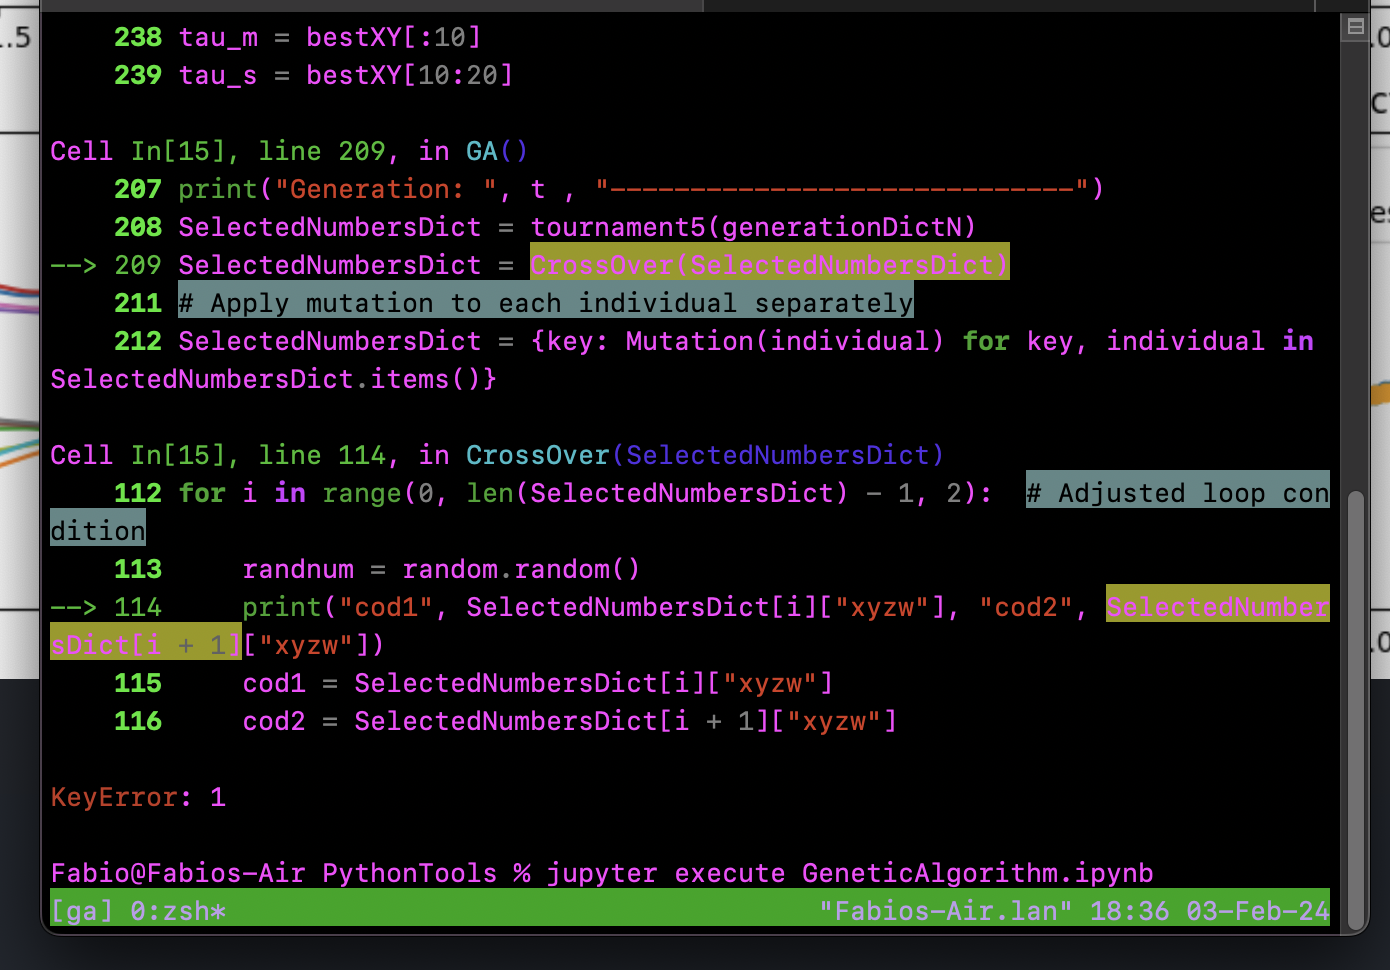

NameError: name 'list_best_fitness' is not defined

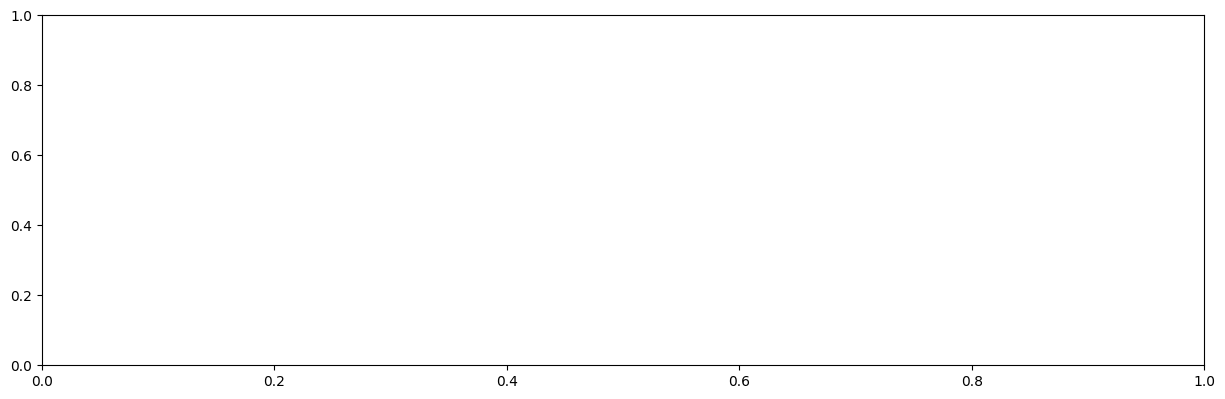

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 2)

#plot the best fitness

plt.plot(list_best_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generation')



#decode the list of best tau_m, tau_s, tau_plus, tau_minus
list_best_tau_m_decoded = []
list_best_tau_s_decoded = []
list_best_tau_plus_decoded = []
list_best_tau_minus_decoded = []

for i in range(len(list_best_tau_m)):
    list_best_tau_m_decoded.append(decode_and_rescale(list_best_tau_m[i], tau_m_MIN, tau_m_MAX, 10))
    list_best_tau_s_decoded.append(decode_and_rescale(list_best_tau_s[i], tau_s_MIN, tau_s_MAX, 10))
    list_best_tau_plus_decoded.append(decode_and_rescale(list_best_tau_plus[i], tau_plus_MIN, tau_plus_MAX, 10))
    list_best_tau_minus_decoded.append(decode_and_rescale(list_best_tau_minus[i], tau_minus_MIN, tau_minus_MAX, 10))

plt.subplot(2, 2, 2)

#plot all the best tau_m, tau_s, tau_plus, tau_minus
plt.plot(list_best_tau_m_decoded, label="tau_m")
plt.plot(list_best_tau_s_decoded, label="tau_s")
plt.plot(list_best_tau_plus_decoded, label="tau_plus")
plt.plot(list_best_tau_minus_decoded, label="tau_minus")

plt.legend(loc="upper left")
plt.show()


In [ ]:
#run fitness function with the best tau_m, tau_s, tau_plus, tau_minus
fitness(300, list_best_tau_m_decoded[-1], list_best_tau_s_decoded[-1], list_best_tau_plus_decoded[-1], list_best_tau_minus_decoded[-1])

Fitness here:  1 0.0666667


-0.9333333